In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parents[0]
sys.path.insert(0, str(PROJECT_ROOT))

from sqlalchemy import text
from src.db import engine


In [2]:
sql = """
CREATE SCHEMA IF NOT EXISTS derived;

DROP MATERIALIZED VIEW IF EXISTS derived.mv_aki_icu_first_cohort;

CREATE MATERIALIZED VIEW derived.mv_aki_icu_first_cohort AS
WITH aki_hadm AS (
  SELECT DISTINCT subject_id, hadm_id
  FROM diagnoses_icd
  WHERE icd9_code LIKE '584%'
),
first_icu AS (
  SELECT DISTINCT ON (subject_id, hadm_id)
    subject_id,
    hadm_id,
    icustay_id,
    intime,
    outtime
  FROM icustays
  ORDER BY subject_id, hadm_id, intime
)
SELECT
  i.subject_id,
  i.hadm_id,
  i.icustay_id,
  i.intime,
  i.outtime,
  p.gender,
  p.dob,
  adm.admittime,
  adm.dischtime,
  adm.deathtime,
  adm.ethnicity,
  EXTRACT(YEAR FROM age(adm.admittime, p.dob)) AS age,
  CASE WHEN adm.deathtime IS NOT NULL THEN 1 ELSE 0 END AS hospital_mortality
FROM first_icu i
JOIN aki_hadm a
  ON a.subject_id = i.subject_id AND a.hadm_id = i.hadm_id
JOIN patients p
  ON p.subject_id = i.subject_id
JOIN admissions adm
  ON adm.subject_id = i.subject_id AND adm.hadm_id = i.hadm_id
WITH NO DATA;

REFRESH MATERIALIZED VIEW derived.mv_aki_icu_first_cohort;

"""

with engine.begin() as conn:
    conn.execute(text(sql))
    conn.execute(text("REFRESH MATERIALIZED VIEW derived.mv_aki_dx_cohort;"))


In [3]:
index_sql = """
CREATE UNIQUE INDEX IF NOT EXISTS idx_mv_aki_icu_first_cohort_icustay
ON derived.mv_aki_icu_first_cohort (icustay_id);

CREATE INDEX IF NOT EXISTS idx_mv_aki_icu_first_cohort_hadm
ON derived.mv_aki_icu_first_cohort (hadm_id);

CREATE INDEX IF NOT EXISTS idx_mv_aki_icu_first_cohort_subject
ON derived.mv_aki_icu_first_cohort (subject_id);
"""
with engine.begin() as conn:
    conn.execute(text(index_sql))


In [3]:
from src.db import q
from src.cohort import load_aki_cohort
df = load_aki_cohort()
df.count()


subject_id            10485
hadm_id               10485
icustay_id            10485
intime                10485
outtime               10485
gender                10485
dob                   10485
admittime             10485
dischtime             10485
deathtime              2295
ethnicity             10485
age                   10485
hospital_mortality    10485
dtype: int64

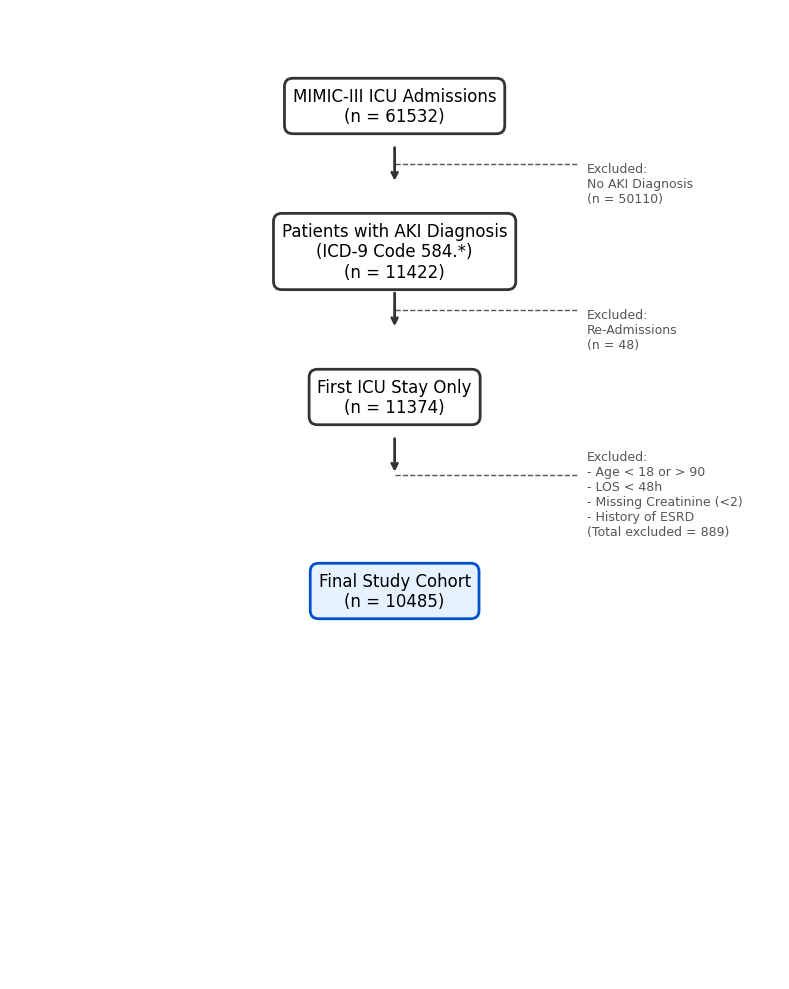

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def draw_consort_diagram(counts):
    """
    Zeichnet ein professionelles Flussdiagramm für die Kohorten-Selektion.
    Passt die Zahlen im 'counts' Dictionary an deine SQL-Ergebnisse an.
    """
    fig, ax = plt.subplots(figsize=(8, 10))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')

    # Styling
    box_props = dict(boxstyle="round,pad=0.5", fc="white", ec="#333333", lw=2)
    arrow_props = dict(arrowstyle="->", color="#333333", lw=2)
    
    # 1. Start Box: Alle ICU Patienten
    ax.text(5, 9, f"MIMIC-III ICU Admissions\n(n = {counts['total_icu']})", 
            ha="center", va="center", size=12, bbox=box_props)

    # Arrow Down
    ax.annotate("", xy=(5, 8.2), xytext=(5, 8.6), arrowprops=arrow_props)

    # 2. Schritt: Diagnose Filter
    n_excluded_diag = counts['total_icu'] - counts['with_diagnosis']
    ax.text(5, 7.5, f"Patients with AKI Diagnosis\n(ICD-9 Code 584.*)\n(n = {counts['with_diagnosis']})", 
            ha="center", va="center", size=12, bbox=box_props)
    
    # Exclusion Text (rechts)
    ax.text(7.5, 8.2, f"Excluded:\nNo AKI Diagnosis\n(n = {n_excluded_diag})", 
            ha="left", va="center", size=9, color="#555555")
    ax.plot([5, 7.4], [8.4, 8.4], color="#555555", lw=1, linestyle="--") # Linie zur Exclusion

    # Arrow Down
    ax.annotate("", xy=(5, 6.7), xytext=(5, 7.1), arrowprops=arrow_props)

    # 3. Schritt: Erste ICU & Basis Filter
    n_excluded_basic = counts['with_diagnosis'] - counts['after_first_icu']
    ax.text(5, 6, f"First ICU Stay Only\n(n = {counts['after_first_icu']})", 
            ha="center", va="center", size=12, bbox=box_props)
    
    # Exclusion Text
    ax.text(7.5, 6.7, f"Excluded:\nRe-Admissions\n(n = {n_excluded_basic})", 
            ha="left", va="center", size=9, color="#555555")
    ax.plot([5, 7.4], [6.9, 6.9], color="#555555", lw=1, linestyle="--")

    # Arrow Down
    ax.annotate("", xy=(5, 5.2), xytext=(5, 5.6), arrowprops=arrow_props)

    # 4. Schritt: Qualitätsfilter (Alter, LOS, Daten)
    n_excluded_qual = counts['after_first_icu'] - counts['final_cohort']
    ax.text(5, 4, f"Final Study Cohort\n(n = {counts['final_cohort']})", 
            ha="center", va="center", size=12, bbox=dict(boxstyle="round,pad=0.5", fc="#e6f2ff", ec="#0052cc", lw=2))

    # Exclusion Text (Detailliert)
    exclusion_text = (
        "Excluded:\n"
        f"- Age < 18 or > 90\n"
        f"- LOS < 48h\n"
        f"- Missing Creatinine (<2)\n"
        f"- History of ESRD\n"
        f"(Total excluded = {n_excluded_qual})"
    )
    ax.text(7.5, 5, exclusion_text, ha="left", va="center", size=9, color="#555555")
    ax.plot([5, 7.4], [5.2, 5.2], color="#555555", lw=1, linestyle="--")

    plt.tight_layout()
    return fig

# --- ANWENDUNG ---

# Hier musst du deine SQL-Counts eintragen (Beispielwerte!):
# 'total_icu': SELECT count(*) FROM icustays
# 'with_diagnosis': SELECT count(*) FROM diagnoses_icd WHERE code like 584...
# 'final_cohort': df.count()

my_counts = {
    'total_icu': 61532,          
    'with_diagnosis': 11422,     
    'after_first_icu': 11374, 
    'final_cohort': 10485      
}

# Plot anzeigen
fig = draw_consort_diagram(my_counts)
plt.show()